# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Import Libraries</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lightning --quiet

In [19]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1.5, font="SimHei", rc={"axes.unicode_minus":False})

import torch
import torchmetrics
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
pl.seed_everything(seed, workers=True)
from torch.utils.data import Subset

Seed set to 1


# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Read Dataset</div>

In [8]:
batch_size = 64

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_path = "/openbayes/input/input2/train"
val_path = "/openbayes/input/input2/val"
test_path = "/openbayes/input/input2/val"

view_dataset = datasets.ImageFolder(root=val_path, transform=transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()]))
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=test_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)

view_loader = DataLoader(view_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Visualization</div>

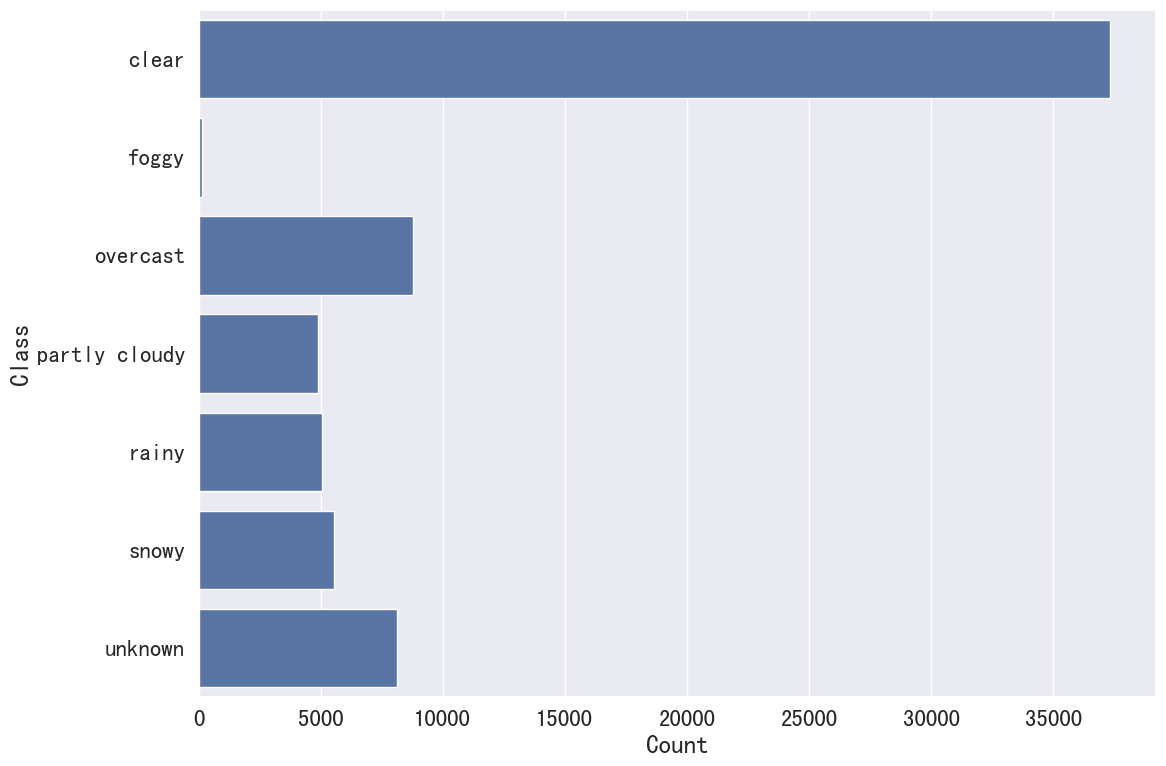

In [9]:
class_names = train_dataset.classes
class_count = [train_dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count})

plt.figure(figsize=(12, 8), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

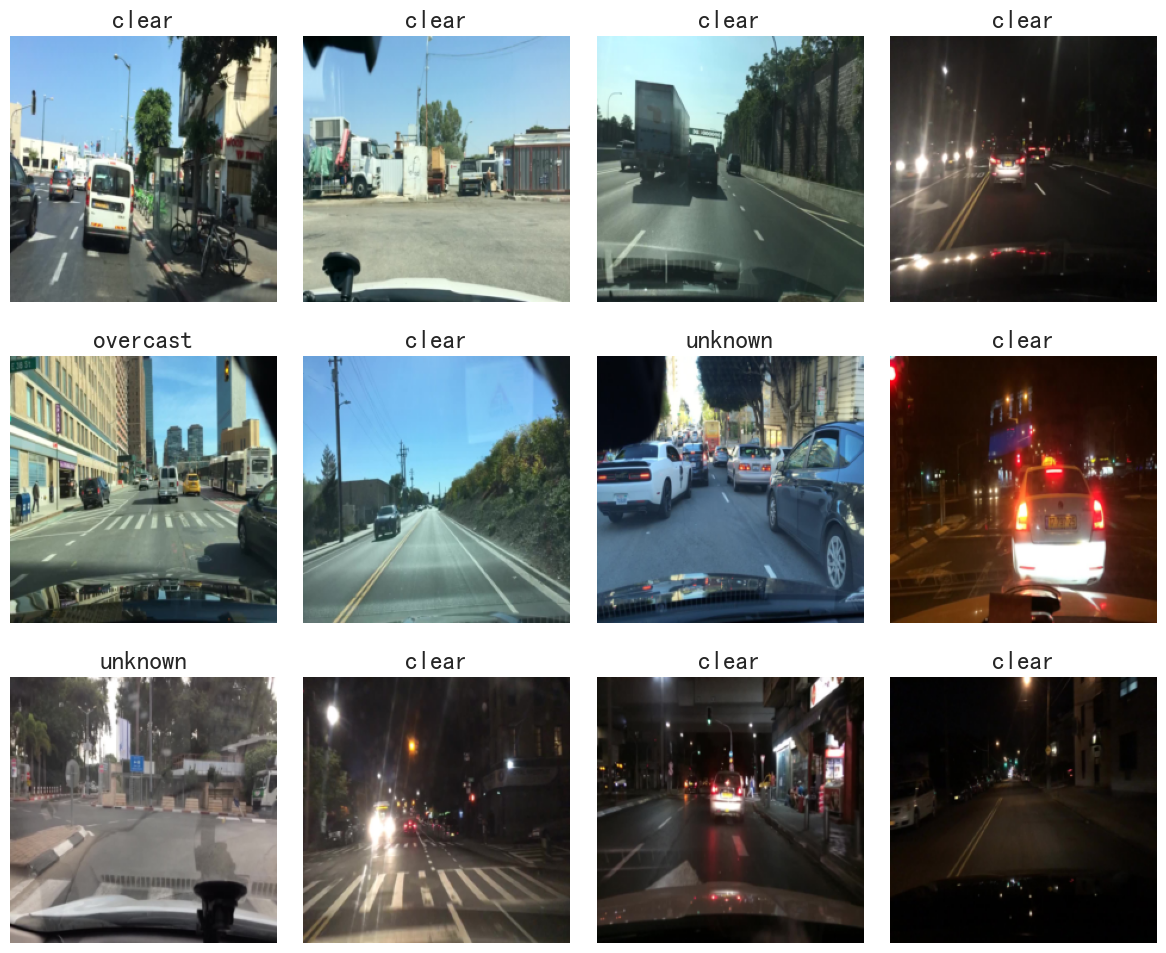

In [10]:
plt.figure(figsize=(12, 10), dpi=100)
images, labels = next(iter(view_loader))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Modeling</div>

In [11]:
class LitModel(pl.LightningModule):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
#         for param in self.model.parameters():
#             param.requires_grad = False
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.precision = torchmetrics.Precision(task="multiclass", average="macro", num_classes=num_classes)
        self.recall = torchmetrics.Recall(task="multiclass", average="macro", num_classes=num_classes)
        self.f1score = torchmetrics.F1Score(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        self.log_dict(
            {
                "train_acc": self.accuracy(y_hat, y),
                "train_prec": self.precision(y_hat, y),
                "train_recall": self.recall(y_hat, y),
                "train_f1score": self.f1score(y_hat, y),
            },
            on_step=True,
            on_epoch=False,
            logger=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, logger=True)
        self.log_dict(
            {
                "val_acc": self.accuracy(y_hat, y),
                "val_prec": self.precision(y_hat, y),
                "val_recall": self.recall(y_hat, y),
                "val_f1score": self.f1score(y_hat, y),
            },
            on_step=False,
            on_epoch=True,
            logger=True,
        )

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        self.log_dict(
            {
                "test_acc": self.accuracy(y_hat, y),
                "test_prec": self.precision(y_hat, y),
                "test_recall": self.recall(y_hat, y),
                "test_f1score": self.f1score(y_hat, y),
            }
        )

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        y_hat = self(x)
        preds = torch.argmax(y_hat, dim=1)
        return preds

In [12]:
num_classes = len(class_names)
model = LitModel(num_classes=num_classes)
logger = CSVLogger("./")
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=0.00, patience=5, verbose=False, mode="min"
)
checkpoint_callback = ModelCheckpoint(monitor="val_loss")
trainer = pl.Trainer(
    max_epochs=20,
    enable_progress_bar=True,
    logger=logger,
    callbacks=[early_stop_callback,checkpoint_callback],
    deterministic=True,
)
trainer.fit(model, train_loader, val_loader)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /output/.torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:27<00:00, 3.13MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: ./lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | model     | EfficientNet        | 20.2 M
1 | accuracy  | MulticlassAccuracy  | 0     
2 | precision |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [13]:
torch.save(model.state_dict(),"/openbayes/home/BDD100K_Weather/model.pth")    

In [14]:
model_path = '/openbayes/home/BDD100K_Weather/model.pth'
model.load_state_dict(torch.load(model_path))
model_Weather = model

In [15]:
trainer.test(model_Weather, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8130999803543091     │
│       test_f1score        │    0.8130999803543091     │
│         test_prec         │     0.752293050289154     │
│        test_recall        │    0.7069509029388428     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8130999803543091,
  'test_prec': 0.752293050289154,
  'test_recall': 0.7069509029388428,
  'test_f1score': 0.8130999803543091}]

In [20]:
total_length = len(val_dataset)

# 计算切片的分割点（一半的位置）
split_point = total_length // 2

# 使用切片操作将 val_dataset 分成两个部分
val_subset = Subset(val_dataset, range(split_point))  # 前一半作为验证集
test_subset = Subset(val_dataset, range(split_point, total_length))  # 后一半作为测试集
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.classification.predictors import ClassWisePredictor

# Preparing a calibration data and a test data.
cal_dataloader = val_loader
test_dataloader = test_loader
# Preparing a pytorch model
model = model_Weather

model.eval()

score_functions = [THR(), APS()]
coverage_rates = []
average_sizes = []
# Options of score function: THR, APS, SAPS, RAPS
# Define a conformal prediction algorithm. Optional: SplitPredictor, ClusterPredictor, ClassWisePredictor
for score in score_functions:
    predictor = ClassWisePredictor(score_function=score, model=model)

# Calibrating the predictor with significance level as 0.1
    predictor.calibrate(cal_dataloader, alpha=0.1)

#########################################
# Predicting for test instances
########################################
# for batch in test_dataloader:
#    test_instances , _ = batch
#    predict_sets = predictor.predict(test_instances)
#    print(predict_sets)

#########################################
# Evaluating the coverage rate and average set size on a given dataset.
########################################
    result_dict = predictor.evaluate(test_dataloader)
    coverage_rates.append(result_dict["Coverage_rate"])
    average_sizes.append(result_dict["Average_size"])
    print(result_dict["Coverage_rate"], result_dict["Average_size"])

0.9005 1.7124
0.9044 1.9225


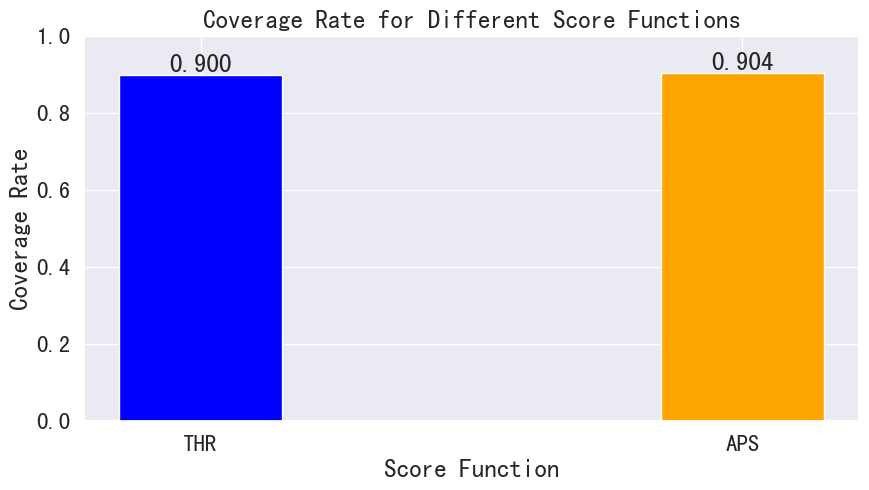

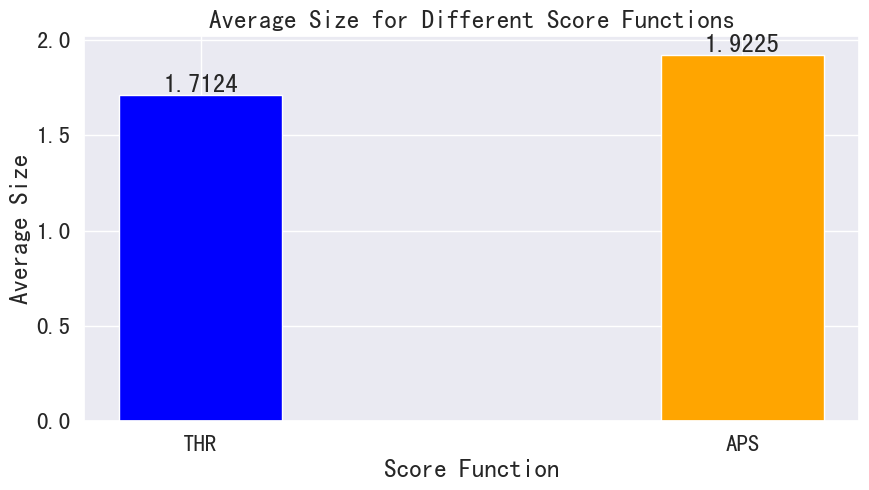

In [24]:
# Assuming you have data for different score functions, Coverage_rate, and Average_size
score_functions = ['THR', 'APS']

# Create a DataFrame for easier plotting

# 绘制Coverage_rate图表
plt.figure(figsize=(10, 5))
bars = plt.bar(score_functions, coverage_rates, color=['blue', 'orange'], width=0.3)
plt.title('Coverage Rate for Different Score Functions')
plt.xlabel('Score Function')
plt.ylabel('Coverage Rate')
plt.ylim(0, 1)  # 设置y轴范围为0到1

# 在每个柱状图上显示相应的值
for bar, value in zip(bars, coverage_rates):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.3f}', ha='center', va='bottom')
plt.savefig('/openbayes/home/BDD100K_Weather/BDD100K_Weather_Coverage_Rates.png')
plt.show()

# 绘制Average_size图表
plt.figure(figsize=(10, 5))
bars = plt.bar(score_functions, average_sizes, color=['blue', 'orange'], width=0.3)
plt.title('Average Size for Different Score Functions')
plt.xlabel('Score Function')
plt.ylabel('Average Size')

# 在每个柱状图上显示相应的值
for bar, value in zip(bars, average_sizes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value}', ha='center', va='bottom')
plt.savefig('/openbayes/home/BDD100K_Weather/BDD100K_Weather_average_sizes.png')
plt.show()